In [ ]:
!pip install kaggle --upgrade --quiet

In [ ]:
import os
from getpass import getpass

In [ ]:
os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

Enter KAGGLE_USERNAME secret value: ··········
Enter KAGGLE_KEY secret value: ··········


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:21<00:00, 129MB/s]
100% 2.29G/2.29G [00:21<00:00, 114MB/s]


In [ ]:
import zipfile
import os


zip_file_path = '/content/chest-xray-pneumonia.zip'


extract_folder = '/content/chest-xray-pneumonia'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)


Extracted files: ['chest_xray']


In [ ]:
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest-xray-pneumonia/chest_xray/train')
test = get_training_data('/content/chest-xray-pneumonia/chest_xray/test')
val = get_training_data('/content/chest-xray-pneumonia/chest_xray/val')

<ipython-input-7-384eb4d7a25f>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], -1)
y_val = np.array(y_val)

x_test = x_test.reshape(x_test.shape[0], -1)
y_test = np.array(y_test)





In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm.SVC())
])


param_grid = {
    'svm__kernel': ['linear', 'poly', 'rbf'],  # Different kernels to try
    'svm__C': [0.1, 1, 10]  # Different values of C (regularization parameter) to try
}

# Create GridSearchCV object with the pipeline and parameters to search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # 5-fold cross-validation

# Perform the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Use the best model for predictions
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Best Parameters: {'svm__C': 10, 'svm__kernel': 'rbf'}
Accuracy: 0.7660256410256411


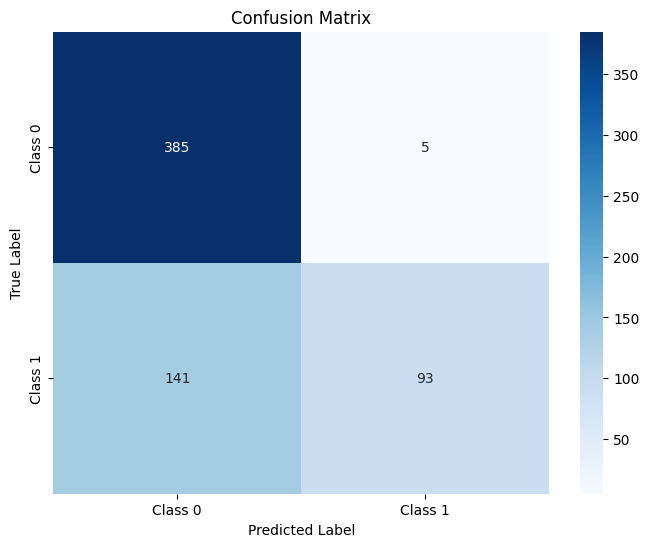

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



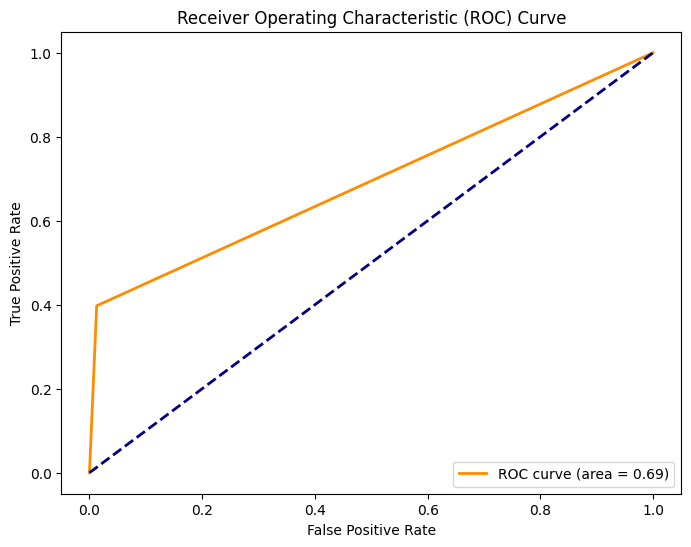

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming predictions and true labels are available (e.g., predictions = clf.predict(X_test), y_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
